In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

ideas:

change in who a county votes for (flips or not) is spatially correlated / informed 

spatial correlation on residuals from a model that predicts winner in each county

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# load the full census election data geojson
census_election_data = gpd.read_file('../../data/election/census/census_master_data.geojson')

In [ ]:
census_election_data.head()

##### Religion

In [ ]:
# open the relgion csv
religion_data = pd.read_csv('religion_groups_county.csv')

In [ ]:
religion_data

In [ ]:
religion_data.isna().sum()

In [ ]:
# drop rows with all NaN in Adherents	Adherents as % of Total Adherents	Adherents as % of Total Population
religion_data = religion_data.dropna(subset=['Adherents', 'Adherents as % of Total Adherents', 'Adherents as % of Total Population'], how='all')

In [ ]:
# drop Congregations column (weird NaN bug)
religion_data = religion_data.drop(columns=['Congregations'])

In [ ]:
# change all values in the religion data to be percentages instead of strings with percentage signs.  also renmove commas from numbers and convert to integers
# Adherents as % of Total Adherents, Adherents as % of Total Population, Adherents
religion_data['Adherents as % of Total Adherents'] = religion_data['Adherents as % of Total Adherents'].str.replace('%', '').str.replace(',', '').astype(float) / 100
religion_data['Adherents as % of Total Population'] = religion_data['Adherents as % of Total Population'].str.replace('%', '').str.replace(',', '').astype(float) / 100
religion_data['Adherents'] = religion_data['Adherents'].str.replace(',', '').astype(int)

In [ ]:
# show the top 5 group names with the most adherents
religion_data.groupby('Group Name')['Adherents'].sum().sort_values(ascending=False).head(20)

In [ ]:
religion_data.groupby('Group Name')['Adherents'].sum().sort_values(ascending=False).head(20).sum()

In [ ]:
religion_data['Group Name'].nunique()

In [ ]:
145119464/161009516

In [ ]:
# drop all rows where the group name is not in the top 20:
# 'Catholic Church', 'Non-denominational Christian Churches',
#        'Southern Baptist Convention', 'United Methodist Church',
#        'Church of Jesus Christ of Latter-day Saints', 'Muslim Estimate',
#        'Evangelical Lutheran Church in America', 'Assemblies of God',
#        'Jehovah's Witnesses', 'National Missionary Baptist Convention, Inc.',
#        'Lutheran Church--Missouri Synod', 'Episcopal Church',
#        'National Baptist Convention, USA, Inc.',
#        'Presbyterian Church (U.S.A.)', 'Churches of Christ',
#        'Christian Churches and Churches of Christ',
#        'Seventh-day Adventist Church', 'American Baptist Churches in the USA',
#        'African Methodist Episcopal Church', 'Orthodox Judaism'],
religion_data = religion_data[religion_data['Group Name'].isin([
    'Catholic Church', 'Non-denominational Christian Churches',
    'Southern Baptist Convention', 'United Methodist Church',
    'Church of Jesus Christ of Latter-day Saints', 'Muslim Estimate',
    'Evangelical Lutheran Church in America', 'Assemblies of God',
    "Jehovah's Witnesses", 'National Missionary Baptist Convention, Inc.',
    'Lutheran Church--Missouri Synod', 'Episcopal Church',
    'National Baptist Convention, USA, Inc.',
    'Presbyterian Church (U.S.A.)', 'Churches of Christ',
    'Christian Churches and Churches of Christ',
    'Seventh-day Adventist Church', 'American Baptist Churches in the USA',
    'African Methodist Episcopal Church', 'Orthodox Judaism'
])]

In [ ]:
len(religion_data['Group Name'].unique())

In [ ]:
import pandas as pd

def transform_religion_data(df):
    """
    Transform religion data from long to wide format with one row per county
    and separate columns for each religion's metrics.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with religion data in long format
    
    Returns:
    pandas.DataFrame: Transformed dataframe with one row per county
    """
    
    # Create base identifier columns for counties
    id_cols = ['FIPS', 'State Name', 'County Name']
    
    # Create three separate pivot tables for each metric
    adherents_pivot = df.pivot(
        index=id_cols,
        columns='Group Name',
        values='Adherents'
    ).add_suffix('_adherents')
    
    pct_adherents_pivot = df.pivot(
        index=id_cols,
        columns='Group Name',
        values='Adherents as % of Total Adherents'
    ).add_suffix('_percent_adherents_of_total_adherents')
    
    pct_pop_pivot = df.pivot(
        index=id_cols,
        columns='Group Name',
        values='Adherents as % of Total Population'
    ).add_suffix('_percent_adherents_of_total_population')
    
    # Combine all pivot tables
    result = pd.concat([
        adherents_pivot,
        pct_adherents_pivot,
        pct_pop_pivot
    ], axis=1)
    
    # Reset index to make FIPS, State Name, and County Name regular columns
    result = result.reset_index()
    
    # Clean up column names and add 'religion_' prefix to all religion-related columns
    result.columns = [
        ('religion_' + col.replace(' ', '_').replace("'", '').replace(',', '').replace('-', '_').lower()
         if col not in id_cols else col.replace(' ', '_').lower())
        for col in result.columns
    ]
    
    return result

In [ ]:
religion_transformed = transform_religion_data(religion_data)

In [ ]:
religion_transformed.fillna(0, inplace=True)

In [ ]:
# drop rows with state_name == 'District of Columbia', 'Alaska', 'Hawaii', 'Puerto Rico'
religion_transformed = religion_transformed[~religion_transformed['state_name'].isin(['District of Columbia', 'Alaska', 'Hawaii', 'Puerto Rico'])]

In [ ]:
# change fips to float
religion_transformed['fips'] = religion_transformed['fips'].astype(float)

In [ ]:
# merge religion_transformed with census_election_data on fips and FIPS Code,respectively
merged_data = pd.merge(census_election_data, religion_transformed, left_on='FIPS Code', right_on='fips', how='inner')

In [ ]:
merged_data

##### Features

In [ ]:
def add_race_percentages(df):
    """
    Add percentage columns for each race category with 'pct_' prefix.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing race population data
    
    Returns:
    pandas.DataFrame: Original DataFrame with new percentage columns added
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Define the years and categories
    years = [2012, 2016, 2020]
    categories = [
        'American Indian and Alaska Native alone',
        'Asian alone',
        'Black or African American alone',
        'Native Hawaiian and Other Pacific Islander alone',
        'Some other race alone',
        'Two or more races:',
        'White alone'
    ]
    
    # Calculate percentages for each year and category for each county
    # iterate over all rows
    for i, row in df.iterrows():
        # iterate over all years
        for year in years:
            # iterate over all categories
            for category in categories:
                # calculate the percentage
                total = row[f'Total:_{year}']
                value = row[f'{category}_{year}']
                pct = round((value / total) , 4)
                # add the percentage to the DataFrame
                df.at[i, f'pct_{category}_{year}'] = pct

    return df

df2 = add_race_percentages(census_election_data)

In [ ]:
# add a column called 'president_winner_{year}' that contains the party of the candidate that won the presidential election in that year

def add_president_winner(df):
    """
    Add a column containing the party of the candidate that won the presidential election in that year.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing election data
    
    Returns:
    pandas.DataFrame: Original DataFrame with new column added
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Define the years
    years = [2012, 2016, 2020]
    
    # Define the election winners
    winners = {
        2012: 'DEM',
        2016: 'GOP',
        2020: 'DEM'
    }
    
    # Add a column for each year containing the party of the election winner
    for year in years:
        df[f'president_winner_{year}'] = winners[year]
    
    return df

In [ ]:
df2 = add_president_winner(df2)

In [ ]:
df2['per_point_diff_2016'] = df2['per_point_diff_2016'].str.replace('%', '').astype(float)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_industry_changes(df):
    """
    Analyzes changes in industry employment percentages across 2012, 2016, and 2020.
    
    Parameters:
    df: DataFrame containing industry employment data
    
    Returns:
    Tuple of (changes_df, summary_stats)
    """
    
    # Define main occupation categories
    occupation_categories = {
        'management': 'pct_management_business_science_arts_occupations',
        'service': 'pct_service_occupations',
        'sales': 'pct_sales_office_occupations',
        'construction': 'pct_natural_resources_construction_maintenance_occupations',
        'production': 'pct_production_transportation_material_moving_occupations'
    }
    
    # Create DataFrame for storing changes
    changes = pd.DataFrame()
    
    # Calculate changes for each category
    for category, suffix in occupation_categories.items():
        # Get values for each year
        col_2012 = f"INDUSTRY_Civilian_employed_population_16_years_and_over_{suffix}_2012"
        col_2016 = f"INDUSTRY_Civilian_employed_population_16_years_and_over_{suffix}_2016"
        col_2020 = f"INDUSTRY_Civilian_employed_population_16_years_and_over_{suffix}_2020"
        
        # Store absolute values
        changes[f'{category}_2012'] = df[col_2012]
        changes[f'{category}_2016'] = df[col_2016]
        changes[f'{category}_2020'] = df[col_2020]
        
        # Calculate changes
        changes[f'{category}_change_12_16'] = df[col_2016] - df[col_2012]
        changes[f'{category}_change_16_20'] = df[col_2020] - df[col_2016]
        changes[f'{category}_change_12_20'] = df[col_2020] - df[col_2012]
        
        # Calculate percentage changes
        changes[f'{category}_pct_change_12_16'] = (
            (df[col_2016] - df[col_2012]) / df[col_2012] * 100
        )
        changes[f'{category}_pct_change_16_20'] = (
            (df[col_2020] - df[col_2016]) / df[col_2016] * 100
        )
        changes[f'{category}_pct_change_12_20'] = (
            (df[col_2020] - df[col_2012]) / df[col_2012] * 100
        )
    
    # Add location identifiers
    changes['county_name'] = df['county_name']
    changes['state_name'] = df['state_name']
    
    # Calculate summary statistics
    summary_stats = {
        'overall_changes': {},
        'top_increasing': {},
        'top_decreasing': {},
        'volatility': {}
    }
    
    for category in occupation_categories.keys():
        # Overall changes
        summary_stats['overall_changes'][category] = {
            '2012-2016': changes[f'{category}_change_12_16'].mean(),
            '2016-2020': changes[f'{category}_change_16_20'].mean(),
            '2012-2020': changes[f'{category}_change_12_20'].mean()
        }
        
        # Top increasing counties
        summary_stats['top_increasing'][category] = changes.nlargest(
            5, f'{category}_change_12_20'
        )[['county_name', 'state_name', f'{category}_change_12_20']]
        
        # Top decreasing counties
        summary_stats['top_decreasing'][category] = changes.nsmallest(
            5, f'{category}_change_12_20'
        )[['county_name', 'state_name', f'{category}_change_12_20']]
        
        # Calculate volatility (standard deviation of changes)
        summary_stats['volatility'][category] = changes[[
            f'{category}_change_12_16',
            f'{category}_change_16_20'
        ]].std().mean()
    
    return changes, summary_stats

def visualize_industry_changes(changes_df):
    """
    Creates visualizations of industry employment changes.
    
    Parameters:
    changes_df: DataFrame containing calculated changes
    
    Returns:
    matplotlib figure
    """
    categories = ['management', 'service', 'sales', 'construction', 'production']
    
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Box plot of percentage changes
    plt.subplot(2, 2, 1)
    change_data = []
    labels = []
    for category in categories:
        change_data.extend([
            changes_df[f'{category}_pct_change_12_16'],
            changes_df[f'{category}_pct_change_16_20']
        ])
        labels.extend([f'{category}\n2012-2016', f'{category}\n2016-2020'])
    
    plt.boxplot(change_data, labels=labels)
    plt.xticks(rotation=45)
    plt.title('Distribution of Percentage Changes by Category and Period')
    plt.ylabel('Percentage Change')
    
    # Plot 2: Average composition over time
    plt.subplot(2, 2, 2)
    years = [2012, 2016, 2020]
    for category in categories:
        values = [
            changes_df[f'{category}_2012'].mean(),
            changes_df[f'{category}_2016'].mean(),
            changes_df[f'{category}_2020'].mean()
        ]
        plt.plot(years, values, marker='o', label=category)
    
    plt.legend()
    plt.title('Average Category Percentages Over Time')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    
    # Plot 3: Heatmap of correlations between changes
    plt.subplot(2, 2, 3)
    change_cols = [f'{cat}_change_12_20' for cat in categories]
    correlation_matrix = changes_df[change_cols].corr()
    
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='RdBu',
        center=0,
        vmin=-1,
        vmax=1
    )
    plt.title('Correlation of Changes Between Categories')
    
    # Plot 4: Scatter plot of most interesting relationship
    plt.subplot(2, 2, 4)
    plt.scatter(
        changes_df['management_change_12_20'],
        changes_df['service_change_12_20'],
        alpha=0.5
    )
    plt.xlabel('Change in Management %')
    plt.ylabel('Change in Service %')
    plt.title('Management vs Service Changes (2012-2020)')
    
    plt.tight_layout()
    return fig

def print_industry_change_summary(summary_stats):
    """
    Prints formatted summary of industry changes.
    
    Parameters:
    summary_stats: Dictionary containing summary statistics
    """
    print("Industry Employment Change Analysis Summary\n")
    
    print("Overall Changes (Percentage Points):")
    for category, changes in summary_stats['overall_changes'].items():
        print(f"\n{category.title()}:")
        print(f"  2012-2016: {changes['2012-2016']:.2f}")
        print(f"  2016-2020: {changes['2016-2020']:.2f}")
        print(f"  2012-2020: {changes['2012-2020']:.2f}")
    
    print("\nMost Volatile Categories (Standard Deviation of Changes):")
    sorted_volatility = sorted(
        summary_stats['volatility'].items(),
        key=lambda x: x[1],
        reverse=True
    )
    for category, volatility in sorted_volatility:
        print(f"{category.title()}: {volatility:.2f}")
    
    print("\nLargest Increasing/Decreasing Counties (2012-2020):")
    for category in summary_stats['top_increasing'].keys():
        print(f"\n{category.title()}:")
        print("  Top Increasing:")
        for _, row in summary_stats['top_increasing'][category].iterrows():
            print(f"    {row['county_name']}, {row['state_name']}: {row[f'{category}_change_12_20']:.2f}%")
        print("  Top Decreasing:")
        for _, row in summary_stats['top_decreasing'][category].iterrows():
            print(f"    {row['county_name']}, {row['state_name']}: {row[f'{category}_change_12_20']:.2f}%")

In [ ]:
# Run analysis
changes_df, summary_stats = analyze_industry_changes(df2)

# Create visualizations
fig = visualize_industry_changes(changes_df)

# Print summary
print_industry_change_summary(summary_stats)

# Show plots
plt.show()

##### Split off data for election results and racial demographics

In [ ]:
def split_columns(df):

    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Define the columns to split off
    columns = [
        'geometry',
        'county_name',
        'state_name',
        'total_votes_2012',
        'votes_dem_2012',
        'votes_gop_2012',
        'per_dem_2012',
        'per_gop_2012',
        'diff_2012',
        'per_point_diff_2012',
        'total_votes_2016',
        'votes_dem_2016',
        'votes_gop_2016',
        'per_dem_2016',
        'per_gop_2016',
        'diff_2016',
        'per_point_diff_2016',
        'votes_gop_2020',
        'votes_dem_2020',
        'total_votes_2020',
        'diff_2020',
        'per_gop_2020',
        'per_dem_2020',
        'per_point_diff_2020',
        'winner_2012',
        'winner_2016',
        'winner_2020',
        'president_winner_2012',
        'president_winner_2016',
        'president_winner_2020',
        'Total:_2012',
        'pct_American Indian and Alaska Native alone_2012',
        'pct_Asian alone_2012',
        'pct_Black or African American alone_2012',
        'pct_Native Hawaiian and Other Pacific Islander alone_2012',
        'pct_Some other race alone_2012',
        'pct_Two or more races:_2012',
        'pct_White alone_2012',
        'Total:_2016',
        'pct_American Indian and Alaska Native alone_2016',
        'pct_Asian alone_2016',
        'pct_Black or African American alone_2016',
        'pct_Native Hawaiian and Other Pacific Islander alone_2016',
        'pct_Some other race alone_2016',
        'pct_Two or more races:_2016',
        'pct_White alone_2016',
        'Total:_2020',
        'pct_American Indian and Alaska Native alone_2020',
        'pct_Asian alone_2020',
        'pct_Black or African American alone_2020',
        'pct_Native Hawaiian and Other Pacific Islander alone_2020',
        'pct_Some other race alone_2020',
        'pct_Two or more races:_2020',
        'pct_White alone_2020',
        'FIPS Code'
    ]

    # Split off the columns
    df = df[columns]

    return df

In [ ]:
df_race_and_election = split_columns(df2)

##### Election voting analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def analyze_and_visualize_elections(df):
    """
    One-line function to analyze and visualize county importance in presidential elections.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing county election data
    
    Returns:
    tuple: (analysis_results, fig) containing dictionary of analysis results and matplotlib figure
    """
    # Calculate metrics (reusing previous analysis logic)
    df['avg_total_votes'] = df[['total_votes_2012', 'total_votes_2016', 'total_votes_2020']].mean(axis=1)
    df['margin_shift_2012_2016'] = df['per_point_diff_2016'] - df['per_point_diff_2012']
    df['margin_shift_2016_2020'] = df['per_point_diff_2020'] - df['per_point_diff_2016']
    df['margin_volatility'] = np.abs(df['margin_shift_2012_2016']) + np.abs(df['margin_shift_2016_2020'])
    df['avg_margin'] = np.abs(df[['per_point_diff_2012', 'per_point_diff_2016', 'per_point_diff_2020']].mean(axis=1))
    df['party_changes'] = ((df['winner_2016'] != df['winner_2012']).astype(int) + 
                          (df['winner_2020'] != df['winner_2016']).astype(int))
    df['electoral_power_index'] = ((df['avg_total_votes'] / df['avg_total_votes'].max()) * 
                                 (1 - (np.abs(df['avg_margin']) / 100)))

    # Create visualization
    fig = plt.figure(figsize=(20, 15))
    
    # Subplot 1: Electoral Power Bubble Plot
    plt.subplot(2, 2, 1)
    plt.scatter(df['avg_margin'], np.log10(df['avg_total_votes']), 
               s=df['electoral_power_index']*1000, alpha=0.5)
    plt.xlabel('Average Margin (%)')
    plt.ylabel('Log10(Average Total Votes)')
    plt.title('County Electoral Power\n(Bubble size = Electoral Power Index)')
    
    # Add annotations for top 10 most important counties
    top_10 = df.nlargest(10, 'electoral_power_index')
    for _, county in top_10.iterrows():
        plt.annotate(f"{county['county_name']}, {county['state_name']}", 
                    (county['avg_margin'], np.log10(county['avg_total_votes'])))
    
    # Subplot 2: Swing County Analysis
    plt.subplot(2, 2, 2)
    swing_counties = df[df['party_changes'] > 0]
    sns.scatterplot(data=swing_counties, x='margin_volatility', y='avg_total_votes', 
                   hue='party_changes', size='avg_total_votes', sizes=(100, 1000))
    plt.title('Swing County Analysis')
    plt.xlabel('Margin Volatility')
    plt.ylabel('Average Total Votes')
    
    # Subplot 3: Demographic Change Impact
    plt.subplot(2, 2, 3)
    demographic_cols_2020 = [col for col in df.columns if col.startswith('pct_') and col.endswith('_2020')]
    demographic_cols_2012 = [col.replace('2020', '2012') for col in demographic_cols_2020]
    total_change = pd.DataFrame()
    for col_2012, col_2020 in zip(demographic_cols_2012, demographic_cols_2020):
        total_change[f'change_{col_2012}'] = df[col_2020] - df[col_2012]
    df['demographic_change_magnitude'] = np.abs(total_change).sum(axis=1)
    
    plt.scatter(df['demographic_change_magnitude'], df['margin_volatility'], 
               c=df['electoral_power_index'], cmap='viridis')
    plt.colorbar(label='Electoral Power Index')
    plt.xlabel('Magnitude of Demographic Change')
    plt.ylabel('Margin Volatility')
    plt.title('Demographic Change vs. Electoral Volatility')
    
    # Subplot 4: County Categories
    plt.subplot(2, 2, 4)
    competitive_threshold = 0.1
    df['category'] = 'Stable'
    df.loc[df['party_changes'] > 0, 'category'] = 'Swing'
    df.loc[(np.abs(df['avg_margin']) < competitive_threshold) & 
           (df['avg_total_votes'] > df['avg_total_votes'].quantile(0.75)), 'category'] = 'Battleground'
    df.loc[df['electoral_power_index'] > df['electoral_power_index'].quantile(0.95), 'category'] = 'High Impact'
    
    category_counts = df['category'].value_counts()
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
    plt.title('Distribution of County Categories')
    
    plt.tight_layout()
    
    # Compile analysis results
    results = {
        'high_impact_counties': df.nlargest(20, 'electoral_power_index')[
            ['county_name', 'state_name', 'electoral_power_index', 'avg_total_votes', 'avg_margin']
        ],
        'swing_counties': df[df['party_changes'] > 0].sort_values(
            by=['party_changes', 'avg_total_votes'], ascending=[False, False]
        )[['county_name', 'state_name', 'party_changes', 'margin_volatility']].head(20),
        'battleground_counties': df[
            (np.abs(df['avg_margin']) < competitive_threshold) &
            (df['avg_total_votes'] > df['avg_total_votes'].quantile(0.75))
        ][['county_name', 'state_name', 'avg_margin', 'avg_total_votes']].head(20),
        'demographic_shift_counties': df.nlargest(20, 'demographic_change_magnitude')[
            ['county_name', 'state_name', 'demographic_change_magnitude']
        ]
    }
    
    return results, fig

# Usage example:
# results, fig = analyze_and_visualize_elections(your_dataframe)
# fig.show()
# print(results)

##### Electoral analysis

In [ ]:
def add_electoral_votes(df):
    """
    Adds electoral vote counts for each state based on 2020/2024 electoral college allocation.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing a state_name column
    
    Returns:
    pandas.DataFrame: Original DataFrame with added electoral_votes column
    """
    
    electoral_votes_dict = {
        'Alabama': 9,
        'Alaska': 3,
        'Arizona': 11,
        'Arkansas': 6,
        'California': 54,
        'Colorado': 10,
        'Connecticut': 7,
        'Delaware': 3,
        'District of Columbia': 3,
        'Florida': 30,
        'Georgia': 16,
        'Hawaii': 4,
        'Idaho': 4,
        'Illinois': 19,
        'Indiana': 11,
        'Iowa': 6,
        'Kansas': 6,
        'Kentucky': 8,
        'Louisiana': 8,
        'Maine': 4,
        'Maryland': 10,
        'Massachusetts': 11,
        'Michigan': 15,
        'Minnesota': 10,
        'Mississippi': 6,
        'Missouri': 10,
        'Montana': 4,
        'Nebraska': 5,
        'Nevada': 6,
        'New Hampshire': 4,
        'New Jersey': 14,
        'New Mexico': 5,
        'New York': 28,
        'North Carolina': 16,
        'North Dakota': 3,
        'Ohio': 17,
        'Oklahoma': 7,
        'Oregon': 8,
        'Pennsylvania': 19,
        'Rhode Island': 4,
        'South Carolina': 9,
        'South Dakota': 3,
        'Tennessee': 11,
        'Texas': 40,
        'Utah': 6,
        'Vermont': 3,
        'Virginia': 13,
        'Washington': 12,
        'West Virginia': 4,
        'Wisconsin': 10,
        'Wyoming': 3
    }
    
    # Create a copy of the dataframe to avoid modifying the original
    df_with_ev = df.copy()
    
    # Add electoral votes column
    df_with_ev['electoral_votes'] = df_with_ev['state_name'].map(electoral_votes_dict)
    
    # Calculate state's share of electoral votes for each county
    df_with_ev['state_total_votes'] = df_with_ev.groupby('state_name')['avg_total_votes'].transform('sum')
    df_with_ev['county_vote_share'] = df_with_ev['avg_total_votes'] / df_with_ev['state_total_votes']
    df_with_ev['county_electoral_importance'] = df_with_ev['county_vote_share'] * df_with_ev['electoral_votes']
    
    # Add columns for electoral importance considering competitiveness
    df_with_ev['competitive_electoral_importance'] = (
        df_with_ev['county_electoral_importance'] * 
        (1 - abs(df_with_ev['avg_margin'])/100)  # Counties with closer margins get higher weight
    )
    
    return df_with_ev

def analyze_state_importance(df_with_ev):
    """
    Analyzes state-level electoral importance based on county data.
    
    Parameters:
    df_with_ev (pandas.DataFrame): DataFrame with electoral vote data added
    
    Returns:
    dict: Different metrics of state importance
    """
    state_analysis = {}
    
    # Aggregate to state level
    state_summary = df_with_ev.groupby('state_name').agg({
        'electoral_votes': 'first',  # Each state has same value for all counties
        'avg_margin': 'mean',
        'margin_volatility': 'mean',
        'avg_total_votes': 'sum',
        'party_changes': 'mean'
    }).reset_index()
    
    # Calculate state importance metrics
    state_summary['state_power_index'] = (
        (state_summary['electoral_votes'] / state_summary['electoral_votes'].max()) *  # Normalized electoral votes
        (1 - abs(state_summary['avg_margin'])/100) *  # Competitiveness factor
        (1 + state_summary['margin_volatility'])  # Volatility bonus
    )
    
    # Get different rankings
    state_analysis['most_powerful_states'] = state_summary.nlargest(10, 'state_power_index')
    state_analysis['most_competitive_states'] = state_summary.nlargest(10, 'margin_volatility')
    state_analysis['largest_electoral_votes'] = state_summary.nlargest(10, 'electoral_votes')
    
    return state_analysis

def visualize_state_importance(df_with_ev):
    """
    Creates visualizations of state electoral importance.
    
    Parameters:
    df_with_ev (pandas.DataFrame): DataFrame with electoral vote data added
    
    Returns:
    matplotlib.figure.Figure: Figure containing visualizations
    """
    fig = plt.figure(figsize=(20, 10))
    
    # State Power Index Plot
    state_summary = df_with_ev.groupby('state_name').agg({
        'electoral_votes': 'first',
        'avg_margin': 'mean',
        'margin_volatility': 'mean'
    }).reset_index()
    
    plt.subplot(1, 2, 1)
    plt.scatter(state_summary['avg_margin'], 
               state_summary['electoral_votes'],
               s=state_summary['margin_volatility']*100,
               alpha=0.6)
    
    # Label important states
    for idx, row in state_summary.nlargest(10, 'electoral_votes').iterrows():
        plt.annotate(row['state_name'], 
                    (row['avg_margin'], row['electoral_votes']))
    
    plt.xlabel('Average Margin (%)')
    plt.ylabel('Electoral Votes')
    plt.title('State Electoral Importance\n(Bubble size = Margin Volatility)')
    
    # Electoral Votes Distribution
    plt.subplot(1, 2, 2)
    state_summary.nlargest(15, 'electoral_votes').plot(
        kind='bar', 
        x='state_name', 
        y='electoral_votes',
        title='Top 15 States by Electoral Votes'
    )
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return fig

In [ ]:
# Run analysis and get visualizations
results, fig = analyze_and_visualize_elections(df_race_and_election)

# Display the visualizations
plt.show()

# View the results
for category, data in results.items():
    print(f"\n{category.replace('_', ' ').title()}:")
    print(data)

##### General spatial correlation

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen, KNN
from esda.moran import Moran, Moran_Local
import warnings
from typing import Union, Tuple, Dict
import mapclassify

def analyze_spatial_correlation(
    gdf: gpd.GeoDataFrame,
    column: str,
    weight_type: str = 'queen',
    k_neighbors: int = 5,
    title: str = None,
    figsize: Tuple[int, int] = (20, 10)
) -> Tuple[Dict, plt.Figure, gpd.GeoDataFrame]:
    """
    Analyzes and visualizes spatial correlation for any column in a GeoDataFrame.
    
    Parameters:
    -----------
    gdf : gpd.GeoDataFrame
        GeoDataFrame containing geometry and data
    column : str
        Name of column to analyze
    weight_type : str, optional (default='queen')
        Type of spatial weights to use ('queen' or 'knn')
    k_neighbors : int, optional (default=5)
        Number of neighbors for KNN weights
    title : str, optional
        Custom title for plots
    figsize : tuple, optional (default=(20, 10))
        Figure size for plots
    """
    # Input validation
    if not isinstance(gdf, gpd.GeoDataFrame):
        raise TypeError("Input must be a GeoDataFrame")
    if column not in gdf.columns:
        raise ValueError(f"Column '{column}' not found in GeoDataFrame")
    
    # Create copy to avoid modifying original
    gdf_analysis = gdf.copy()
    
    # Handle missing values
    if gdf_analysis[column].isnull().any():
        print(f"Warning: {gdf_analysis[column].isnull().sum()} missing values found and will be removed")
        gdf_analysis = gdf_analysis.dropna(subset=[column])
    
    # Create spatial weights matrix
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if weight_type.lower() == 'queen':
            weights = Queen.from_dataframe(gdf_analysis, use_index=True)
        elif weight_type.lower() == 'knn':
            weights = KNN.from_dataframe(gdf_analysis, k=k_neighbors)
        else:
            raise ValueError("weight_type must be either 'queen' or 'knn'")
    
    # Handle islands if using queen weights
    if weight_type.lower() == 'queen':
        islands = weights.islands
        if len(islands) > 0:
            print(f"Removing {len(islands)} isolated areas from analysis")
            gdf_analysis = gdf_analysis[~gdf_analysis.index.isin(islands)].copy()
            weights = Queen.from_dataframe(gdf_analysis, use_index=True)
    
    weights.transform = 'r'  # Row-standardize weights
    
    # Calculate Global Moran's I
    moran = Moran(gdf_analysis[column], weights)
    
    # Calculate Local Moran's I
    local_moran = Moran_Local(gdf_analysis[column], weights)
    
    # Add local indicators to dataframe
    gdf_analysis['local_moran_i'] = local_moran.Is
    gdf_analysis['local_moran_p'] = local_moran.p_sim
    
    # Classify clusters
    gdf_analysis['cluster_type'] = 'Not Significant'
    sig_mask = local_moran.p_sim < 0.05
    
    # Standardize values for clustering
    std_val = (gdf_analysis[column] - gdf_analysis[column].mean()) / gdf_analysis[column].std()
    lag_val = weights.sparse.dot(std_val)
    
    # Assign cluster types
    gdf_analysis.loc[sig_mask & (std_val > 0) & (lag_val > 0), 'cluster_type'] = 'High-High'
    gdf_analysis.loc[sig_mask & (std_val < 0) & (lag_val < 0), 'cluster_type'] = 'Low-Low'
    gdf_analysis.loc[sig_mask & (std_val > 0) & (lag_val < 0), 'cluster_type'] = 'High-Low'
    gdf_analysis.loc[sig_mask & (std_val < 0) & (lag_val > 0), 'cluster_type'] = 'Low-High'
    
    # Create visualizations
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Original Values
    plot1 = gdf_analysis.plot(
        column=column,
        ax=axes[0],
        legend=True,
        cmap='viridis'
    )
    axes[0].set_title(f"Distribution of {column}")
    axes[0].axis('off')
    
    # Add colorbar with label
    cbar1 = plt.colorbar(plot1.get_children()[0], ax=axes[0])
    cbar1.set_label(column, rotation=270, labelpad=15)
    
    # Plot 2: Local Moran's I Values
    plot2 = gdf_analysis.plot(
        column='local_moran_i',
        ax=axes[1],
        legend=True,
        cmap='RdBu'
    )
    axes[1].set_title("Local Moran's I Values")
    axes[1].axis('off')
    
    # Add colorbar with label
    cbar2 = plt.colorbar(plot2.get_children()[0], ax=axes[1])
    cbar2.set_label("Local Moran's I", rotation=270, labelpad=15)
    
    # Plot 3: Cluster Types with categorical legend
    cluster_colors = {'High-High': '#d7191c', 
                     'Low-Low': '#2c7bb6', 
                     'High-Low': '#fdae61', 
                     'Low-High': '#abd9e9', 
                     'Not Significant': '#ffffbf'}
    
    for cluster_type, color in cluster_colors.items():
        mask = gdf_analysis['cluster_type'] == cluster_type
        if mask.any():
            gdf_analysis[mask].plot(
                color=color,
                ax=axes[2],
                label=cluster_type
            )
    
    axes[2].set_title('Spatial Clusters')
    axes[2].axis('off')
    axes[2].legend(title='Cluster Type', bbox_to_anchor=(1.3, 1))
    
    if title:
        fig.suptitle(title, fontsize=16, y=1.05)
    
    plt.tight_layout()
    
    # Calculate summary statistics
    results = {
        'global_statistics': {
            'morans_i': moran.I,
            'p_value': moran.p_sim,
            'z_score': moran.z_sim
        },
        'cluster_summary': gdf_analysis['cluster_type'].value_counts().to_dict(),
        'local_statistics': {
            'mean_local_i': gdf_analysis['local_moran_i'].mean(),
            'significant_clusters': (gdf_analysis['local_moran_p'] < 0.05).sum(),
            'percent_significant': (gdf_analysis['local_moran_p'] < 0.05).mean() * 100
        }
    }
    
    return results, fig, gdf_analysis

def print_spatial_correlation_results(results: Dict, column_name: str = "selected variable"):
    """
    Prints formatted spatial correlation analysis results.
    """
    print(f"Spatial Correlation Analysis Results for {column_name}\n")
    
    print("Global Moran's I Statistics:")
    print(f"Moran's I: {results['global_statistics']['morans_i']:.3f}")
    print(f"P-value: {results['global_statistics']['p_value']:.3f}")
    print(f"Z-score: {results['global_statistics']['z_score']:.3f}")
    
    print("\nLocal Statistics:")
    print(f"Mean Local Moran's I: {results['local_statistics']['mean_local_i']:.3f}")
    print(f"Number of Significant Clusters: {results['local_statistics']['significant_clusters']}")
    print(f"Percent Significant: {results['local_statistics']['percent_significant']:.1f}%")
    
    print("\nCluster Type Distribution:")
    for cluster_type, count in results['cluster_summary'].items():
        print(f"{cluster_type}: {count} areas")

In [ ]:
# Basic usage
results, fig, gdf_analyzed = analyze_spatial_correlation(
    gdf=df2,
    column='per_dem_2012'
)

# Print results
print_spatial_correlation_results(results)

# Show plots
plt.show()

##### Vote Flipping

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda.moran import Moran
import folium
from matplotlib.colors import LinearSegmentedColormap

def analyze_spatial_vote_flipping(df):
    """
    Analyzes spatial correlation in county voting pattern changes.
    
    Parameters:
    df (GeoDataFrame): DataFrame containing county election data and geometries
    
    Returns:
    tuple: (analysis_results, figures) containing statistics and visualizations
    """
    # Convert to GeoDataFrame if not already
    gdf = gpd.GeoDataFrame(df) if not isinstance(df, gpd.GeoDataFrame) else df
    
    # Calculate flips between elections
    gdf['flip_2012_2016'] = (gdf['winner_2012'] != gdf['winner_2016']).astype(int)
    gdf['flip_2016_2020'] = (gdf['winner_2016'] != gdf['winner_2020']).astype(int)
    gdf['total_flips'] = gdf['flip_2012_2016'] + gdf['flip_2016_2020']
    
    # Create spatial weights matrix using Queen contiguity
    weights = Queen.from_dataframe(gdf)
    weights.transform = 'r'  # Row-standardize weights
    
    # Calculate Moran's I for different periods
    moran_2012_2016 = Moran(gdf['flip_2012_2016'], weights)
    moran_2016_2020 = Moran(gdf['flip_2016_2020'], weights)
    moran_total = Moran(gdf['total_flips'], weights)
    
    # Calculate local Moran's I for clustering analysis
    from esda.moran import Moran_Local
    local_moran = Moran_Local(gdf['total_flips'], weights)
    
    # Add cluster categories to the dataframe
    gdf['cluster_category'] = 'Not Significant'
    # High-High
    gdf.loc[(local_moran.p_sim < 0.05) & (gdf['total_flips'] > gdf['total_flips'].mean()) & 
            (local_moran.q == 1), 'cluster_category'] = 'High-High'
    # Low-Low
    gdf.loc[(local_moran.p_sim < 0.05) & (gdf['total_flips'] < gdf['total_flips'].mean()) & 
            (local_moran.q == 2), 'cluster_category'] = 'Low-Low'
    # High-Low
    gdf.loc[(local_moran.p_sim < 0.05) & (gdf['total_flips'] > gdf['total_flips'].mean()) & 
            (local_moran.q == 3), 'cluster_category'] = 'High-Low'
    # Low-High
    gdf.loc[(local_moran.p_sim < 0.05) & (gdf['total_flips'] < gdf['total_flips'].mean()) & 
            (local_moran.q == 4), 'cluster_category'] = 'Low-High'
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Plot 1: 2012-2016 flips
    gdf.plot(column='flip_2012_2016', 
            ax=axes[0,0],
            legend=True,
            legend_kwds={'label': 'County Flipped 2012-2016'},
            cmap='RdBu')
    axes[0,0].set_title("County Flips 2012-2016")
    axes[0,0].axis('off')
    
    # Plot 2: 2016-2020 flips
    gdf.plot(column='flip_2016_2020',
            ax=axes[0,1],
            legend=True,
            legend_kwds={'label': 'County Flipped 2016-2020'},
            cmap='RdBu')
    axes[0,1].set_title("County Flips 2016-2020")
    axes[0,1].axis('off')
    
    # Plot 3: Total flips
    gdf.plot(column='total_flips',
            ax=axes[1,0],
            legend=True,
            legend_kwds={'label': 'Total Flips'},
            cmap='viridis')
    axes[1,0].set_title("Total County Flips 2012-2020")
    axes[1,0].axis('off')
    
    # Plot 4: Cluster categories
    gdf.plot(column='cluster_category',
            ax=axes[1,1],
            legend=True,
            legend_kwds={'label': 'Spatial Clusters'},
            categorical=True,
            cmap='Set3')
    axes[1,1].set_title("Spatial Clustering of Flips")
    axes[1,1].axis('off')
    
    # Compile results
    results = {
        'global_spatial_correlation': {
            '2012-2016': {
                'morans_i': moran_2012_2016.I,
                'p_value': moran_2012_2016.p_sim
            },
            '2016-2020': {
                'morans_i': moran_2016_2020.I,
                'p_value': moran_2016_2020.p_sim
            },
            'total': {
                'morans_i': moran_total.I,
                'p_value': moran_total.p_sim
            }
        },
        'cluster_summary': gdf['cluster_category'].value_counts().to_dict(),
        'flip_summary': {
            'total_flipping_counties_2012_2016': gdf['flip_2012_2016'].sum(),
            'total_flipping_counties_2016_2020': gdf['flip_2016_2020'].sum(),
            'counties_that_flipped_twice': len(gdf[gdf['total_flips'] == 2])
        }
    }
    
    return results, fig, gdf

def print_spatial_analysis_results(results):
    """
    Prints formatted analysis results
    """
    print("Spatial Correlation Analysis of County Vote Flipping\n")
    
    print("Global Moran's I Statistics:")
    for period, stats in results['global_spatial_correlation'].items():
        print(f"\n{period}:")
        print(f"Moran's I: {stats['morans_i']:.3f}")
        print(f"P-value: {stats['p_value']:.3f}")
    
    print("\nCluster Analysis:")
    for cluster_type, count in results['cluster_summary'].items():
        print(f"{cluster_type}: {count} counties")
    
    print("\nFlip Summary:")
    for metric, value in results['flip_summary'].items():
        print(f"{metric.replace('_', ' ').title()}: {value}")

In [ ]:
# Run the analysis
results, fig, gdf_with_clusters = analyze_spatial_vote_flipping(df_race_and_election)

# Print the results
print_spatial_analysis_results(results)

# Show the maps
plt.show()

##### County election importance

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_county_importance(gdf, state_electoral_votes=None):
    """
    Analyzes county importance in presidential elections based on multiple factors.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with county election data and geometries
    state_electoral_votes : dict, optional
        Dictionary of state electoral votes. If None, uses 2020 allocation.
        
    Returns:
    --------
    GeoDataFrame with importance metrics, Figure with visualizations
    """
    
    # Electoral votes by state (2020/2024 allocation)
    if state_electoral_votes is None:
        state_electoral_votes = {
            'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 54,
            'Colorado': 10, 'Connecticut': 7, 'Delaware': 3, 'District of Columbia': 3,
            'Florida': 30, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 19,
            'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8,
            'Maine': 4, 'Maryland': 10, 'Massachusetts': 11, 'Michigan': 15,
            'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10, 'Montana': 4,
            'Nebraska': 5, 'Nevada': 6, 'New Hampshire': 4, 'New Jersey': 14,
            'New Mexico': 5, 'New York': 28, 'North Carolina': 16, 'North Dakota': 3,
            'Ohio': 17, 'Oklahoma': 7, 'Oregon': 8, 'Pennsylvania': 19,
            'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3,
            'Tennessee': 11, 'Texas': 40, 'Utah': 6, 'Vermont': 3, 'Virginia': 13,
            'Washington': 12, 'West Virginia': 4, 'Wisconsin': 10, 'Wyoming': 3
        }
    
    # Create working copy
    gdf = gdf.copy()
    
    # Add electoral votes
    gdf['electoral_votes'] = gdf['state_name'].map(state_electoral_votes)
    
    # Calculate metrics
    
    # 1. Average margin across elections (closer = more important)
    gdf['avg_margin'] = np.abs(pd.concat([
        gdf['per_point_diff_2012'],
        gdf['per_point_diff_2016'],
        gdf['per_point_diff_2020']
    ], axis=1)).mean(axis=1)
    
    # 2. Margin volatility (more volatile = more important)
    gdf['margin_volatility'] = np.abs(
        gdf['per_point_diff_2016'] - gdf['per_point_diff_2012']
    ) + np.abs(
        gdf['per_point_diff_2020'] - gdf['per_point_diff_2016']
    )
    
    # 3. Average total votes (more votes = more important)
    gdf['avg_total_votes'] = pd.concat([
        gdf['total_votes_2012'],
        gdf['total_votes_2016'],
        gdf['total_votes_2020']
    ], axis=1).mean(axis=1)
    
    # 4. County's share of state's electoral votes
    gdf['state_total_votes'] = gdf.groupby('state_name')['avg_total_votes'].transform('sum')
    gdf['electoral_vote_share'] = (
        gdf['avg_total_votes'] / gdf['state_total_votes'] * gdf['electoral_votes']
    )
    
    # 5. Calculate swing state bonus
    gdf['swing_state_bonus'] = (
        (1 - np.abs(gdf['per_point_diff_2020'] / 100)) * 
        (gdf['margin_volatility'] / gdf['margin_volatility'].max())
    )
    
    # Calculate final importance score
    # Normalize components
    for col in ['avg_margin', 'margin_volatility', 'avg_total_votes', 'electoral_vote_share']:
        gdf[f'{col}_norm'] = (gdf[col] - gdf[col].min()) / (gdf[col].max() - gdf[col].min())
    
    gdf['importance_score'] = (
        (1 - gdf['avg_margin_norm']) * 0.3 +  # Close margins (30% weight)
        gdf['margin_volatility_norm'] * 0.2 +  # Volatility (20% weight)
        gdf['avg_total_votes_norm'] * 0.2 +    # Vote volume (20% weight)
        gdf['electoral_vote_share'] * 0.2 +    # Electoral importance (20% weight)
        gdf['swing_state_bonus'] * 0.1         # Swing state bonus (10% weight)
    )
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Plot 1: Overall Importance Score
    gdf.plot(
        column='importance_score',
        ax=axes[0,0],
        legend=True,
        cmap='viridis',
        legend_kwds={'label': 'County Importance Score'}
    )
    axes[0,0].set_title('County Electoral Importance')
    axes[0,0].axis('off')
    
    # Plot 2: Margin Volatility
    gdf.plot(
        column='margin_volatility',
        ax=axes[0,1],
        legend=True,
        cmap='RdYlBu',
        legend_kwds={'label': 'Margin Volatility'}
    )
    axes[0,1].set_title('County Vote Margin Volatility')
    axes[0,1].axis('off')
    
    # Plot 3: Electoral Vote Share
    gdf.plot(
        column='electoral_vote_share',
        ax=axes[1,0],
        legend=True,
        cmap='Reds',
        legend_kwds={'label': 'Electoral Vote Share'}
    )
    axes[1,0].set_title('County Share of Electoral Votes')
    axes[1,0].axis('off')
    
    # Plot 4: Swing State Bonus
    gdf.plot(
        column='swing_state_bonus',
        ax=axes[1,1],
        legend=True,
        cmap='coolwarm',
        legend_kwds={'label': 'Swing State Bonus'}
    )
    axes[1,1].set_title('Swing State Importance')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    
    # Get top counties
    top_counties = gdf.nlargest(20, 'importance_score')[
        ['county_name', 'state_name', 'importance_score', 
         'avg_margin', 'margin_volatility', 'electoral_vote_share']
    ]
    
    return gdf, fig, top_counties

def print_importance_analysis(top_counties):
    """
    Prints formatted analysis of most important counties
    """
    print("\nMost Important Counties for Electoral Victory:\n")
    
    for idx, county in top_counties.iterrows():
        print(f"{county['county_name']}, {county['state_name']}")
        print(f"  Importance Score: {county['importance_score']:.3f}")
        print(f"  Average Margin: {county['avg_margin']:.1f}%")
        print(f"  Margin Volatility: {county['margin_volatility']:.1f}")
        print(f"  Electoral Vote Share: {county['electoral_vote_share']:.3f}")
        print()

In [ ]:
# Run the analysis
gdf_with_importance, fig, top_counties = analyze_county_importance(df_race_and_election)

# Print the results
print_importance_analysis(top_counties)

# Show the maps
plt.show()

##### Gentriification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_gentrification(df):
    """
    Analyzes county-level gentrification using multiple indicators.
    
    Parameters:
    df: DataFrame containing county-level census and demographic data
    
    Returns:
    DataFrame with gentrification scores and component metrics
    """
    # Create working copy
    gdf = df.copy()
    
    # 1. Educational Change (2012-2020)
    gdf['edu_change_score'] = (
        (gdf["Percent of adults with a bachelor's degree or higher, 2018-22"] -
         gdf["Percent of adults with a bachelor's degree or higher, 2008-12"]) / 
        gdf["Percent of adults with a bachelor's degree or higher, 2008-12"]
    )
    
    # 2. Income Changes (using median household income)
    gdf['income_change_score'] = (
        (gdf['Median_Household_Income_2021'] -
         gdf['median_household_income_dollars_occupied_housing_units_2012']) /
        gdf['median_household_income_dollars_occupied_housing_units_2012']
    )
    
    # 3. Demographic Changes (2012-2020)
    gdf['demographic_change_score'] = (
        # Change in white population percentage
        np.abs(gdf['pct_White alone_2020'] - gdf['pct_White alone_2012']) +
        # Change in Black population percentage
        np.abs(gdf['pct_Black or African American alone_2020'] - gdf['pct_Black or African American alone_2012']) +
        # Change in Asian population percentage
        np.abs(gdf['pct_Asian alone_2020'] - gdf['pct_Asian alone_2012'])
    )
    
    # 4. Housing Cost Changes
    # Calculate change in housing costs using rent data
    gdf['housing_cost_change_score'] = (
        (gdf['median_dollars_occupied_housing_units_2016'] -  # Using 2016 as endpoint due to data availability
         gdf['median_dollars_occupied_housing_units_2012']) /
        gdf['median_dollars_occupied_housing_units_2012']
    )
    
    # 5. Employment Changes
    gdf['employment_change_score'] = (
        (gdf['Unemployment_rate_2022'] - gdf['Unemployment_rate_2012'])
    )
    
    # Calculate overall gentrification score
    # Normalize each component
    for col in ['edu_change_score', 'income_change_score', 'demographic_change_score', 
                'housing_cost_change_score', 'employment_change_score']:
        gdf[f'{col}_norm'] = (gdf[col] - gdf[col].min()) / (gdf[col].max() - gdf[col].min())
    
    # Weighted combination for final score
    gdf['gentrification_score'] = (
        gdf['edu_change_score_norm'] * 0.25 +              # Education change
        gdf['income_change_score_norm'] * 0.25 +           # Income change
        gdf['demographic_change_score_norm'] * 0.2 +       # Demographic change
        gdf['housing_cost_change_score_norm'] * 0.2 +      # Housing cost change
        gdf['employment_change_score_norm'] * 0.1          # Employment change
    )
    
    # Categorize gentrification levels
    gdf['gentrification_level'] = pd.qcut(
        gdf['gentrification_score'], 
        q=5, 
        labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    )
    
    return gdf

def visualize_gentrification(gdf):
    """
    Creates visualizations of gentrification analysis.
    
    Parameters:
    gdf: GeoDataFrame with gentrification metrics
    
    Returns:
    matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Plot 1: Overall Gentrification Score
    gdf.plot(
        column='gentrification_score',
        ax=axes[0,0],
        legend=True,
        cmap='RdYlBu_r',
        legend_kwds={'label': 'Gentrification Score'}
    )
    axes[0,0].set_title('Overall Gentrification Score')
    axes[0,0].axis('off')
    
    # Plot 2: Education and Income Changes
    ax2 = axes[0,1].scatter(
        gdf['edu_change_score'],
        gdf['income_change_score'],
        c=gdf['gentrification_score'],
        cmap='RdYlBu_r',
        alpha=0.6
    )
    axes[0,1].set_xlabel('Educational Attainment Change')
    axes[0,1].set_ylabel('Income Change')
    axes[0,1].set_title('Education vs Income Changes')
    plt.colorbar(ax2, ax=axes[0,1], label='Gentrification Score')
    
    # Plot 3: Housing Cost Change
    gdf.plot(
        column='housing_cost_change_score',
        ax=axes[1,0],
        legend=True,
        cmap='Reds',
        legend_kwds={'label': 'Housing Cost Change'}
    )
    axes[1,0].set_title('Housing Cost Changes')
    axes[1,0].axis('off')
    
    # Plot 4: Demographic Change
    gdf.plot(
        column='demographic_change_score',
        ax=axes[1,1],
        legend=True,
        cmap='viridis',
        legend_kwds={'label': 'Demographic Change Score'}
    )
    axes[1,1].set_title('Demographic Changes')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    return fig

def print_gentrification_summary(gdf):
    """
    Prints summary statistics and identifies most gentrified counties.
    
    Parameters:
    gdf: GeoDataFrame with gentrification metrics
    """
    print("Gentrification Analysis Summary\n")
    
    # Overall statistics
    print("Overall Statistics:")
    print(f"Mean Gentrification Score: {gdf['gentrification_score'].mean():.3f}")
    print(f"Median Gentrification Score: {gdf['gentrification_score'].median():.3f}")
    
    print("\nDistribution by Gentrification Level:")
    print(gdf['gentrification_level'].value_counts())
    
    print("\nTop 10 Most Gentrified Counties:")
    top_10 = gdf.nlargest(10, 'gentrification_score')[
        ['county_name', 'state_name', 'gentrification_score', 
         'edu_change_score', 'income_change_score', 'housing_cost_change_score']
    ]
    for idx, row in top_10.iterrows():
        print(f"\n{row['county_name']}, {row['state_name']}")
        print(f"  Gentrification Score: {row['gentrification_score']:.3f}")
        print(f"  Education Change: {row['edu_change_score']:.1%}")
        print(f"  Income Change: {row['income_change_score']:.1%}")
        print(f"  Housing Cost Change: {row['housing_cost_change_score']:.1%}")

In [ ]:
# Run analysis
gdf_with_gentrification = analyze_gentrification(df2)

# Create visualizations
fig = visualize_gentrification(gdf_with_gentrification)

# Print summary statistics
print_gentrification_summary(gdf_with_gentrification)

# Show plots
plt.show()

#### Other stuff

In [ ]:
columns_to_select = [
    'geometry', 'county_name', 'state_name',
    
    # Election data 2012
    'total_votes_2012', 'votes_dem_2012', 'votes_gop_2012',
    'per_dem_2012', 'per_gop_2012', 'diff_2012', 'per_point_diff_2012',
    
    # Election data 2016
    'total_votes_2016', 'votes_dem_2016', 'votes_gop_2016',
    'per_dem_2016', 'per_gop_2016', 'diff_2016', 'per_point_diff_2016',
    
    # Election data 2020
    'votes_gop_2020', 'votes_dem_2020', 'total_votes_2020',
    'diff_2020', 'per_gop_2020', 'per_dem_2020', 'per_point_diff_2020',
    
    # Winners
    'winner_2012', 'winner_2016', 'winner_2020',
    
    # Race data 2012
    'Total:_2012',
    'pct_American Indian and Alaska Native alone_2012',
    'pct_Asian alone_2012',
    'pct_Black or African American alone_2012',
    'pct_Native Hawaiian and Other Pacific Islander alone_2012',
    'pct_Some other race alone_2012',
    'pct_Two or more races:_2012',
    'pct_White alone_2012',
    
    # Race data 2016
    'Total:_2016',
    'pct_American Indian and Alaska Native alone_2016',
    'pct_Asian alone_2016',
    'pct_Black or African American alone_2016',
    'pct_Native Hawaiian and Other Pacific Islander alone_2016',
    'pct_Some other race alone_2016',
    'pct_Two or more races:_2016',
    'pct_White alone_2016',
    
    # Race data 2020
    'Total:_2020',
    'pct_American Indian and Alaska Native alone_2020',
    'pct_Asian alone_2020',
    'pct_Black or African American alone_2020',
    'pct_Native Hawaiian and Other Pacific Islander alone_2020',
    'pct_Some other race alone_2020',
    'pct_Two or more races:_2020',
    'pct_White alone_2020',
]

subset_df = df2[columns_to_select]

In [ ]:
subset_df

In [ ]:
# change the per_point_dff_2016 column values from strings with percent signs to floats
subset_df['per_point_diff_2016'] = subset_df['per_point_diff_2016'].str.replace('%', '').astype(float)

In [ ]:
# plot the subsset_df , color by a value
subset_df.plot(column='pct_White alone_2012', legend=True, figsize=(15, 15), cmap='Blues')
plt.show()

In [ ]:
# save all col names to a file
with open('data/other/all_col_names.txt', 'w') as f:
    for col in census_election_data.columns:
        f.write(f'{col}\n')

In [ ]:
# show columns that have VALUE in the name
value = 'Metro'
total_columns = [col for col in census_election_data.columns if value in col]
print(total_columns)

In [ ]:
# show count of metro 2013 vals
print(census_election_data['Metro_2013'].value_counts())

In [ ]:
# show the counties with the largest changes in per_gop_2012 to per_gop_2016 (already columns)
census_election_data['gop_change'] = census_election_data['per_gop_2016'] - census_election_data['per_gop_2012']
census_election_data['gop_change_abs'] = abs(census_election_data['gop_change'])
census_election_data = census_election_data.sort_values('gop_change_abs', ascending=False)
print(census_election_data[['county_name', 'gop_change', 'gop_change_abs']].head(10))

In [ ]:
# plot counties by Metro_2013 (0=non-metro, 1=metro)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
census_election_data.plot(column='Metro_2013', ax=ax, legend=True)
plt.title('Metro_2013')
plt.show()

#### ML / Stats

In [ ]:
census_election_data.dtypes.value_counts()

# show all column names that are object type
object_columns = census_election_data.select_dtypes(include='object').columns
print(object_columns)

##### Correlations

In [ ]:
# calculate correlation between all columns.  this should be returned in the form of a list with the top 100 highest ocrrelating pairs
correlation_matrix = census_election_data.corr().abs()
correlation_values = correlation_matrix.unstack().sort_values(ascending=False)
correlation_values = correlation_values[correlation_values < 1]
correlation_values = correlation_values[0:100]
print(correlation_values)

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

def analyze_correlations(df, top_n=20, min_correlation=0.0):
    """
    Analyze correlations between all numeric columns in a dataframe with formatted output.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    top_n (int): Number of top correlations to return
    min_correlation (float): Minimum absolute correlation value to consider
    
    Returns:
    pandas.DataFrame: Top correlations sorted by absolute value
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Convert correlation matrix to long format
    correlations = []
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 < col2:  # Only take upper triangle to avoid duplicates
                correlation = corr_matrix.loc[col1, col2]
                if abs(correlation) >= min_correlation:
                    correlations.append({
                        'Variable 1': col1,
                        'Variable 2': col2,
                        'Correlation': correlation,
                        'Absolute Correlation': abs(correlation)
                    })
    
    # Convert to dataframe and sort
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('Absolute Correlation', ascending=False)
    
    # Format correlation values
    corr_df['Correlation'] = corr_df['Correlation'].round(3)
    
    # Create formatted output
    # result = corr_df.head(top_n)[['Variable 1', 'Variable 2', 'Correlation']]
    result = corr_df[['Variable 1', 'Variable 2', 'Correlation']]
    
    # # Print formatted results
    # print("\nTop", top_n, "Correlations:")
    # print("=" * 100)
    # for idx, row in result.iterrows():
    #     print(f"\nCorrelation: {row['Correlation']:.3f}")
    #     print(f"Variable 1: {row['Variable 1']}")
    #     print(f"Variable 2: {row['Variable 2']}")
    #     print("-" * 100)
    
    return result

# Example usage:
# top_correlations = analyze_correlations(df, top_n=20)

In [ ]:
top_correlations = analyze_correlations(census_election_data, top_n=1836)

In [ ]:
# # drop all perfect correlations (1 or -1)
# top_correlations = top_correlations[top_correlations['Correlation'] < 1]
# top_correlations = top_correlations[top_correlations['Correlation'] > -1]

In [ ]:
# function to filter the top_correlations dataframe by a string in either Variable 1 or Variable 2 (separately), as well as a correlation value range
def filter_correlations(correlations, filter_str=None, min_correlation=None, max_correlation=None):
    """
    Filter correlation dataframe by variable names and correlation values.
    
    Parameters:
    correlations (pandas.DataFrame): DataFrame with correlation values
    filter_str (str): String to filter variable names
    min_correlation (float): Minimum correlation value
    max_correlation (float): Maximum correlation value
    
    Returns:
    pandas.DataFrame: Filtered correlation dataframe
    """
    # Filter by variable names
    if filter_str:
        correlations = correlations[
            correlations['Variable 1'].str.contains(filter_str) | 
            correlations['Variable 2'].str.contains(filter_str)
        ]
    
    # Filter by correlation values
    if min_correlation:
        correlations = correlations[correlations['Correlation'] >= min_correlation]
    if max_correlation:
        correlations = correlations[correlations['Correlation'] <= max_correlation]
    
    return correlations

In [ ]:
var_filter = 'religion'
min_corr = 0.7
max_corr = 1
filtered_correlations = filter_correlations(top_correlations, filter_str=var_filter, min_correlation=min_corr, max_correlation=max_corr)
# filtered_correlations = filter_correlations(top_correlations, min_correlation=min_corr, max_correlation=max_corr)
filtered_correlations

In [ ]:
county_dataframe = pd.DataFrame(census_election_data.drop(columns=['geometry']))

In [ ]:
county_dataframe

In [212]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

class FeatureImportanceAnalyzer:
    def __init__(self):
        self.model = None
        self.feature_importances = None
        self.selected_features = None
        self.target = None
        self.scaler = StandardScaler()
        
    def _preprocess_data(self, df, columns_to_drop=None):
        """
        Preprocess the data by handling missing values and non-numeric columns.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        columns_to_drop : list
            List of strings - columns containing any of these strings will be dropped
        """
        # Create a copy of the dataframe
        df_processed = df.copy()
        
        # Drop columns containing any of the strings in columns_to_drop
        if columns_to_drop:
            # Get all columns that contain any of the strings to drop
            cols_to_drop = []
            for pattern in columns_to_drop:
                matching_cols = df_processed.columns[df_processed.columns.str.contains(pattern, case=False)]
                cols_to_drop.extend(matching_cols)
            
            # Remove duplicates and ensure we don't drop the target
            cols_to_drop = list(set([col for col in cols_to_drop if col != self.target]))
            
            # Drop the columns
            df_processed = df_processed.drop(columns=cols_to_drop, errors='ignore')
            
            print(f"Dropped {len(cols_to_drop)} columns containing the patterns: {columns_to_drop}")
        
        # Handle missing values
        for column in df_processed.columns:
            if df_processed[column].dtype in ['int64', 'float64']:
                df_processed[column].fillna(df_processed[column].mean(), inplace=True)
            else:
                df_processed[column].fillna(df_processed[column].mode()[0], inplace=True)
        
        # Get numeric columns only, making sure to include the target column
        numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
        if self.target not in numeric_cols:
            numeric_cols = numeric_cols.append(pd.Index([self.target]))
        
        return df_processed[numeric_cols]

    def analyze_importance(self, df, target_column, columns_to_drop=None, n_features=20):
        """
        Analyze feature importance for a given target column.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        target_column : str
            Name of the target column
        columns_to_drop : list
            List of strings - columns containing any of these strings will be dropped
        n_features : int, optional
            Number of top features to return (default=20)
            
        Returns:
        --------
        dict : Dictionary containing:
            - feature_importances: DataFrame with feature importances
            - model_performance: Dict with R² and RMSE scores
            - model: Trained RandomForestRegressor
        """
        # Store target
        self.target = target_column
        
        # Preprocess data
        df_processed = self._preprocess_data(df, columns_to_drop)
        
        # Verify target column is present
        if target_column not in df_processed.columns:
            raise ValueError(f"Target column '{target_column}' not found in processed data")
        
        # Separate features and target
        X = df_processed.drop(columns=[target_column])
        y = df_processed[target_column]
        
        # Store selected features
        self.selected_features = X.columns.tolist()
        
        # Print number of features being used
        print(f"Using {len(self.selected_features)} features for analysis")
        
        # Split the data
        print("Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale the features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train model
        print("Training model...")
        self.model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
        self.model.fit(X_train_scaled, y_train)
        
        # Get predictions
        y_pred = self.model.predict(X_test_scaled)
        
        # Calculate performance metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Get feature importances
        importances = self.model.feature_importances_
        self.feature_importances = pd.DataFrame({
            'feature': self.selected_features,
            'importance': importances
        }).sort_values('importance', ascending=False).head(n_features)
        
        return {
            'feature_importances': self.feature_importances,
            'model_performance': {
                'r2_score': r2,
                'rmse': rmse
            },
            'model': self.model
        }
    
    def plot_importance(self, n_features=20):
        """Plot feature importance using matplotlib."""
        try:
            import matplotlib.pyplot as plt
            
            plt.figure(figsize=(12, 8))
            plt.barh(self.feature_importances['feature'][:n_features],
                    self.feature_importances['importance'][:n_features])
            plt.xlabel('Feature Importance')
            plt.title(f'Top {n_features} Most Important Features for {self.target}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        except ImportError:
            print("matplotlib is required for plotting. Please install it first.")

In [ ]:
# Create analyzer instance
analyzer = FeatureImportanceAnalyzer()

# Define patterns to drop - any column containing these strings will be dropped
columns_to_drop = ['white', 'male', 'female']

# Analyze importance for a target variable
results = analyzer.analyze_importance(
    df=county_dataframe,
    target_column='white_alone_total_2020',
    columns_to_drop=columns_to_drop
)

# Print results
print("\nTop 10 Most Important Features:")
print(results['feature_importances'].head(10))

print("\nModel Performance:")
print(f"R² Score: {results['model_performance']['r2_score']:.4f}")
print(f"RMSE: {results['model_performance']['rmse']:.4f}")

# Plot results
analyzer.plot_importance(n_features=15)

In [ ]:
# show columns with religion in the name
religion_columns = [col for col in county_dataframe.columns if 'muslim' in col]
print(religion_columns)

In [216]:
# show row where religion_jehovahs_witnesses_percent_adherents_of_total_population is max
max_row = county_dataframe[county_dataframe['religion_jehovahs_witnesses_percent_adherents_of_total_population'] == county_dataframe['religion_jehovahs_witnesses_percent_adherents_of_total_population'].max()]
max_row.county_name

2714    Upton County
Name: county_name, dtype: object

In [218]:
max_row['Total:_2020']

2714    3651
Name: Total:_2020, dtype: int32

##### Maps

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

def plot_choropleth(
    gdf,
    feature_name,
    scale='linear',
    figsize=(15, 10),
    cmap='YlOrRd',
    title=None,
    legend_label=None
):
    """
    Create a choropleth map from a GeoDataFrame with flexible scaling options.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The geodataframe containing geographic and feature data
    feature_name : str
        The column name of the feature to plot
    scale : str, default 'linear'
        The scale type ('linear' or 'log')
    figsize : tuple, default (15, 10)
        Figure size as (width, height)
    cmap : str, default 'YlOrRd'
        Matplotlib colormap name
    title : str, optional
        Custom title for the plot. If None, will generate based on feature name
    legend_label : str, optional
        Custom label for the legend. If None, will use feature name
        
    Returns:
    --------
    fig, ax : tuple
        The figure and axis objects for further customization if needed
    """
    # Input validation
    if feature_name not in gdf.columns:
        raise ValueError(f"Feature '{feature_name}' not found in the GeoDataFrame")
    
    if scale not in ['linear', 'log']:
        raise ValueError("Scale must be either 'linear' or 'log'")
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Prepare the normalization
    if scale == 'log':
        # Handle zero or negative values for log scale
        min_val = gdf[feature_name].min()
        if min_val <= 0:
            print(f"Warning: Data contains values ≤ 0. Adding offset for log scale.")
            gdf = gdf.copy()
            gdf[feature_name] = gdf[feature_name] - min_val + 1
        
        norm = LogNorm(
            vmin=gdf[feature_name].min(),
            vmax=gdf[feature_name].max()
        )
    else:
        norm = None
    
    # Generate default title and legend label if not provided
    if title is None:
        title = f"{feature_name} by County"
        if scale == 'log':
            title += " (Log Scale)"
            
    if legend_label is None:
        legend_label = feature_name
        if scale == 'log':
            legend_label += " (log scale)"
    
    # Create the plot
    gdf.plot(
        column=feature_name,
        ax=ax,
        legend=True,
        legend_kwds={
            'label': legend_label,
            'orientation': 'vertical'
        },
        cmap=cmap,
        norm=norm
    )
    
    # Customize the appearance
    plt.title(title, pad=20)
    ax.axis('off')
    plt.tight_layout()
    
    return fig, ax

(<Figure size 1500x1000 with 2 Axes>,
 <Axes: title={'center': 'Under 5 years_total_2020 by County (Log Scale)'}>)

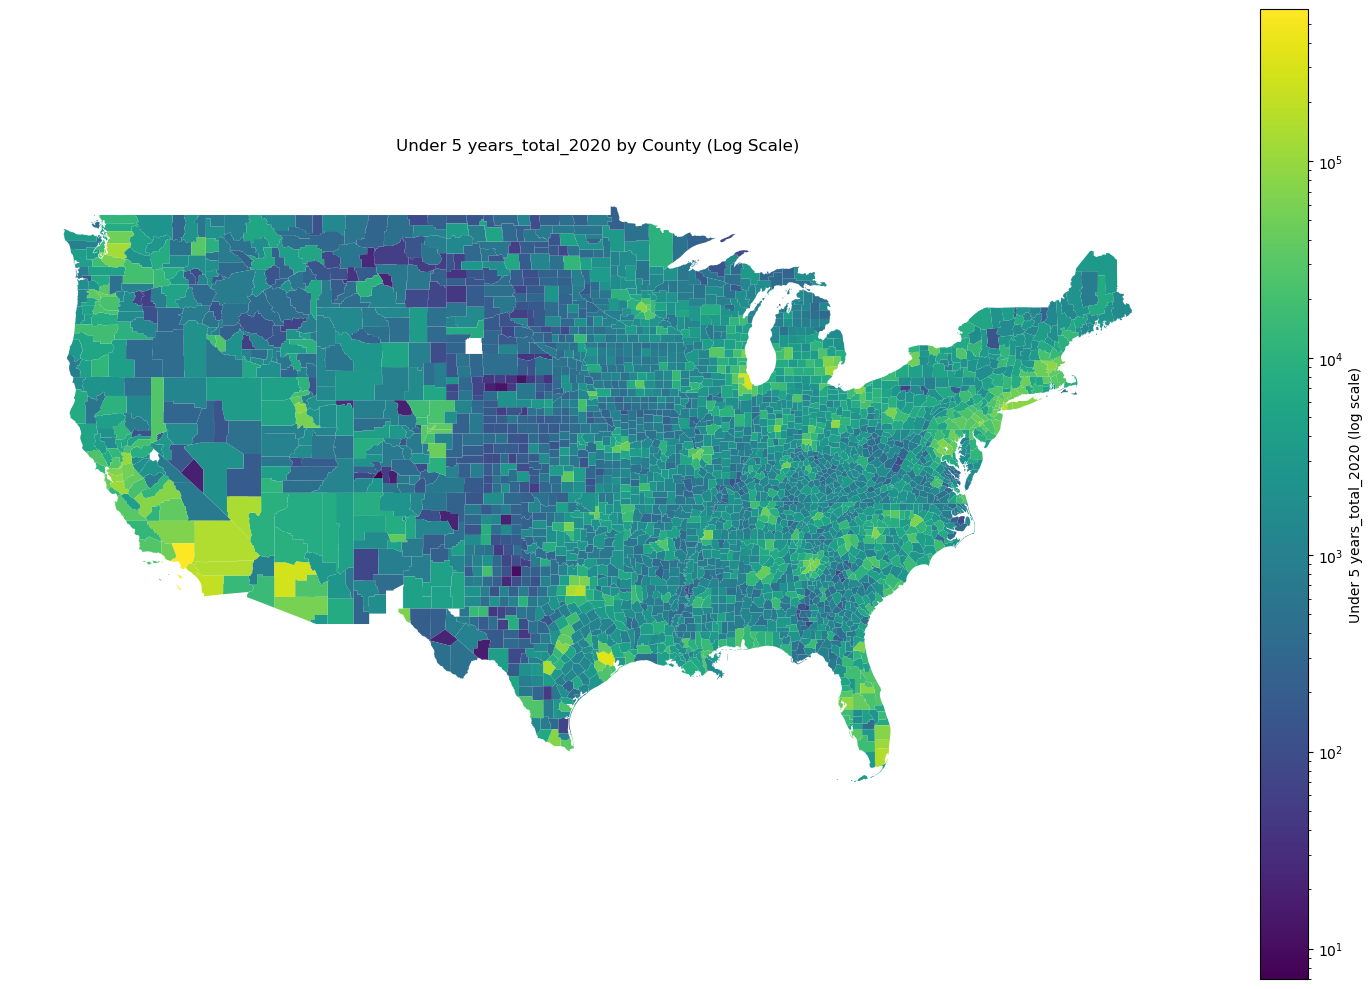

In [222]:
plot_choropleth(census_election_data, 'Under 5 years_total_2020', scale='log', cmap='viridis')